In [1]:
trial_number_ml = "008"
random_state_init = 888

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 17:28:59,947] A new study created in memory with name: no-name-26a8ab18-998a-4e83-b48f-f600591e1bc2


[I 2024-05-01 17:29:35,341] Trial 0 finished with value: 0.7293552352218124 and parameters: {'n_estimators': 146, 'max_depth': 96, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7293552352218124.


[I 2024-05-01 17:30:55,183] Trial 2 finished with value: 0.7280823657290302 and parameters: {'n_estimators': 519, 'max_depth': 94, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7293552352218124.


[I 2024-05-01 17:31:19,688] Trial 1 finished with value: 0.7277628785339143 and parameters: {'n_estimators': 653, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7293552352218124.


[I 2024-05-01 17:31:35,407] Trial 4 finished with value: 0.7252095206168288 and parameters: {'n_estimators': 685, 'max_depth': 89, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.7293552352218124.


[I 2024-05-01 17:31:42,328] Trial 5 finished with value: 0.7325450278852893 and parameters: {'n_estimators': 257, 'max_depth': 39, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 5 with value: 0.7325450278852893.


[I 2024-05-01 17:31:53,589] Trial 3 finished with value: 0.7322306199778543 and parameters: {'n_estimators': 751, 'max_depth': 76, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.7325450278852893.


[I 2024-05-01 17:31:55,210] Trial 8 pruned. 


[I 2024-05-01 17:32:00,810] Trial 10 pruned. 


[I 2024-05-01 17:32:02,688] Trial 7 pruned. 


[I 2024-05-01 17:32:43,205] Trial 9 finished with value: 0.7293562510793486 and parameters: {'n_estimators': 233, 'max_depth': 75, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.7325450278852893.


[I 2024-05-01 17:33:13,950] Trial 11 finished with value: 0.7376431089304035 and parameters: {'n_estimators': 316, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.7376431089304035.


[I 2024-05-01 17:33:45,477] Trial 6 finished with value: 0.7274393279086542 and parameters: {'n_estimators': 889, 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 11 with value: 0.7376431089304035.


[I 2024-05-01 17:33:54,519] Trial 12 finished with value: 0.7379656436981279 and parameters: {'n_estimators': 468, 'max_depth': 97, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.7379656436981279.


[I 2024-05-01 17:34:43,456] Trial 15 finished with value: 0.7309450522658703 and parameters: {'n_estimators': 350, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 12 with value: 0.7379656436981279.


[I 2024-05-01 17:35:28,082] Trial 16 finished with value: 0.7395600321010981 and parameters: {'n_estimators': 389, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.7395600321010981.


[I 2024-05-01 17:35:45,650] Trial 18 pruned. 


[I 2024-05-01 17:35:51,095] Trial 13 finished with value: 0.7357307571186216 and parameters: {'n_estimators': 961, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.7395600321010981.


[I 2024-05-01 17:36:03,691] Trial 17 finished with value: 0.7217022724733083 and parameters: {'n_estimators': 392, 'max_depth': 54, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.7395600321010981.


[I 2024-05-01 17:36:11,475] Trial 14 finished with value: 0.7334953626103475 and parameters: {'n_estimators': 961, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.7395600321010981.


[I 2024-05-01 17:37:45,089] Trial 19 finished with value: 0.7408339174514167 and parameters: {'n_estimators': 484, 'max_depth': 57, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:38:03,740] Trial 20 finished with value: 0.7395585083147939 and parameters: {'n_estimators': 534, 'max_depth': 62, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:38:23,619] Trial 21 finished with value: 0.7408323936651124 and parameters: {'n_estimators': 563, 'max_depth': 65, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:38:26,830] Trial 22 finished with value: 0.7392385131909102 and parameters: {'n_estimators': 538, 'max_depth': 66, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:38:53,074] Trial 25 pruned. 


[I 2024-05-01 17:39:52,237] Trial 23 finished with value: 0.7392395290484461 and parameters: {'n_estimators': 552, 'max_depth': 64, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:40:08,716] Trial 24 finished with value: 0.7398769796523735 and parameters: {'n_estimators': 577, 'max_depth': 62, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:40:16,583] Trial 28 pruned. 


[I 2024-05-01 17:40:24,146] Trial 26 finished with value: 0.7389241052834752 and parameters: {'n_estimators': 607, 'max_depth': 51, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:40:35,879] Trial 29 pruned. 


[I 2024-05-01 17:40:43,424] Trial 30 pruned. 


[I 2024-05-01 17:40:50,515] Trial 31 pruned. 


[I 2024-05-01 17:40:58,504] Trial 33 pruned. 


[I 2024-05-01 17:41:10,234] Trial 27 finished with value: 0.7401995144200978 and parameters: {'n_estimators': 781, 'max_depth': 51, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:41:50,487] Trial 32 finished with value: 0.7322255406901736 and parameters: {'n_estimators': 490, 'max_depth': 60, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:42:07,353] Trial 35 finished with value: 0.7363722711526937 and parameters: {'n_estimators': 387, 'max_depth': 58, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:42:13,719] Trial 34 finished with value: 0.7376466644317802 and parameters: {'n_estimators': 473, 'max_depth': 58, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:42:40,569] Trial 39 pruned. 


[I 2024-05-01 17:44:06,930] Trial 36 finished with value: 0.7386015705157509 and parameters: {'n_estimators': 862, 'max_depth': 71, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:44:43,804] Trial 41 pruned. 


[I 2024-05-01 17:44:50,226] Trial 38 finished with value: 0.7370097217566209 and parameters: {'n_estimators': 697, 'max_depth': 70, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:45:09,739] Trial 37 finished with value: 0.7382830991781713 and parameters: {'n_estimators': 851, 'max_depth': 71, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7408339174514167.


[I 2024-05-01 17:45:13,713] Trial 42 pruned. 


[I 2024-05-01 17:45:21,882] Trial 43 pruned. 


[I 2024-05-01 17:45:36,584] Trial 40 finished with value: 0.7414723839128801 and parameters: {'n_estimators': 692, 'max_depth': 41, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.7414723839128801.


[I 2024-05-01 17:45:39,479] Trial 46 pruned. 


[I 2024-05-01 17:45:41,430] Trial 44 pruned. 


[I 2024-05-01 17:46:07,549] Trial 49 pruned. 


[I 2024-05-01 17:46:11,724] Trial 48 pruned. 


[I 2024-05-01 17:46:19,286] Trial 45 finished with value: 0.738602078444519 and parameters: {'n_estimators': 295, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.7414723839128801.


[I 2024-05-01 17:46:35,251] Trial 47 finished with value: 0.738602586373287 and parameters: {'n_estimators': 675, 'max_depth': 41, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.7414723839128801.


Best trial for RandomForestClassifier:
  Value: 0.7414723839128801
  Params: 
    n_estimators: 692
    max_depth: 41
    min_samples_split: 9
    min_samples_leaf: 3
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 692, 'max_depth': 41, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


[I 2024-05-01 17:46:48,288] A new study created in memory with name: no-name-69eb386b-31f7-47fd-8302-9d50a94fbbcb


RandomForestClassifier accuracy: 0.7248



[I 2024-05-01 17:47:01,590] Trial 3 finished with value: 0.7245741017279737 and parameters: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.06113777061169498, 'min_child_weight': 6, 'subsample': 0.7624520863284319, 'colsample_bytree': 0.9464045474304297, 'gamma': 3.310091769687012, 'reg_lambda': 0.024414171094674003, 'reg_alpha': 0.26045429584217167}. Best is trial 3 with value: 0.7245741017279737.


[I 2024-05-01 17:47:04,957] Trial 2 finished with value: 0.717238594459513 and parameters: {'n_estimators': 358, 'max_depth': 8, 'learning_rate': 0.2615019633508314, 'min_child_weight': 9, 'subsample': 0.9186589983536757, 'colsample_bytree': 0.7858715337868336, 'gamma': 4.1160361035468584, 'reg_lambda': 1.6183318537998084, 'reg_alpha': 0.059999180916065174}. Best is trial 3 with value: 0.7245741017279737.


[I 2024-05-01 17:47:14,245] Trial 1 finished with value: 0.7127774560895579 and parameters: {'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.10758244553909807, 'min_child_weight': 1, 'subsample': 0.5639645711147816, 'colsample_bytree': 0.9081014737999537, 'gamma': 3.4443883030850597, 'reg_lambda': 0.41409149153691316, 'reg_alpha': 0.09902108131170204}. Best is trial 3 with value: 0.7245741017279737.


[I 2024-05-01 17:47:19,060] Trial 5 finished with value: 0.7181960401873242 and parameters: {'n_estimators': 265, 'max_depth': 8, 'learning_rate': 0.21300155781561206, 'min_child_weight': 10, 'subsample': 0.8305553048150829, 'colsample_bytree': 0.9425581101900127, 'gamma': 4.8689484879487015, 'reg_lambda': 1.1747781993869517, 'reg_alpha': 2.6249223078974047}. Best is trial 3 with value: 0.7245741017279737.


[I 2024-05-01 17:47:23,429] Trial 0 finished with value: 0.7274403437661903 and parameters: {'n_estimators': 716, 'max_depth': 8, 'learning_rate': 0.07204312771900877, 'min_child_weight': 3, 'subsample': 0.9821629244832893, 'colsample_bytree': 0.5313540114520379, 'gamma': 0.798149811199515, 'reg_lambda': 2.569313373116587, 'reg_alpha': 0.028025767232976395}. Best is trial 0 with value: 0.7274403437661903.


[I 2024-05-01 17:47:25,022] Trial 7 pruned. 


[I 2024-05-01 17:47:26,100] Trial 4 finished with value: 0.7280813498714941 and parameters: {'n_estimators': 477, 'max_depth': 6, 'learning_rate': 0.0660144610464646, 'min_child_weight': 8, 'subsample': 0.9661926396973861, 'colsample_bytree': 0.9154863368314071, 'gamma': 3.1457373885713213, 'reg_lambda': 5.136897068616024, 'reg_alpha': 0.9637558904176733}. Best is trial 4 with value: 0.7280813498714941.


[I 2024-05-01 17:47:28,410] Trial 8 pruned. 


[I 2024-05-01 17:47:30,342] Trial 11 pruned. 


[I 2024-05-01 17:47:31,400] Trial 10 pruned. 


[I 2024-05-01 17:47:34,531] Trial 12 pruned. 


[I 2024-05-01 17:47:39,197] Trial 6 finished with value: 0.7156436981277745 and parameters: {'n_estimators': 501, 'max_depth': 9, 'learning_rate': 0.2491973919627226, 'min_child_weight': 5, 'subsample': 0.5252435904957582, 'colsample_bytree': 0.7532909655931412, 'gamma': 3.7306742254688867, 'reg_lambda': 8.325169852016339, 'reg_alpha': 0.02082537942573524}. Best is trial 4 with value: 0.7280813498714941.


[I 2024-05-01 17:47:39,200] Trial 13 pruned. 


[I 2024-05-01 17:47:44,575] Trial 16 pruned. 


[I 2024-05-01 17:47:45,075] Trial 15 pruned. 


[I 2024-05-01 17:47:49,373] Trial 17 pruned. 


[I 2024-05-01 17:47:56,389] Trial 9 finished with value: 0.7258495108645964 and parameters: {'n_estimators': 508, 'max_depth': 6, 'learning_rate': 0.02136851403661079, 'min_child_weight': 10, 'subsample': 0.812381076361191, 'colsample_bytree': 0.63164152445522, 'gamma': 4.6869328053763555, 'reg_lambda': 9.685935334109278, 'reg_alpha': 0.04073360820974382}. Best is trial 4 with value: 0.7280813498714941.


[I 2024-05-01 17:47:59,695] Trial 20 pruned. 


[I 2024-05-01 17:48:01,814] Trial 21 pruned. 


[I 2024-05-01 17:48:09,576] Trial 22 pruned. 


[I 2024-05-01 17:48:11,160] Trial 18 finished with value: 0.7366887107752008 and parameters: {'n_estimators': 269, 'max_depth': 6, 'learning_rate': 0.016957098387659623, 'min_child_weight': 4, 'subsample': 0.8929430329788153, 'colsample_bytree': 0.6813203959098262, 'gamma': 0.10816764773513388, 'reg_lambda': 0.1095076183561843, 'reg_alpha': 0.03946343239128299}. Best is trial 18 with value: 0.7366887107752008.


[I 2024-05-01 17:48:19,471] Trial 19 finished with value: 0.7258464632919879 and parameters: {'n_estimators': 382, 'max_depth': 6, 'learning_rate': 0.043633097488509485, 'min_child_weight': 5, 'subsample': 0.8165518171455026, 'colsample_bytree': 0.86998897891471, 'gamma': 1.9361377541076732, 'reg_lambda': 0.1493248583862675, 'reg_alpha': 0.031801998494027185}. Best is trial 18 with value: 0.7366887107752008.


[I 2024-05-01 17:48:22,213] Trial 25 pruned. 


[I 2024-05-01 17:48:25,883] Trial 26 pruned. 


[I 2024-05-01 17:48:28,603] Trial 24 finished with value: 0.7350882272270136 and parameters: {'n_estimators': 208, 'max_depth': 6, 'learning_rate': 0.04458770773056195, 'min_child_weight': 4, 'subsample': 0.941460099498457, 'colsample_bytree': 0.5849923497347982, 'gamma': 0.11658117134312154, 'reg_lambda': 0.06769016386240718, 'reg_alpha': 0.02794878843910552}. Best is trial 18 with value: 0.7366887107752008.


[I 2024-05-01 17:48:31,332] Trial 14 finished with value: 0.7290347321691606 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.012769408670778304, 'min_child_weight': 3, 'subsample': 0.9913870534499195, 'colsample_bytree': 0.5155264054185631, 'gamma': 2.1537177398820835, 'reg_lambda': 9.134609820016465, 'reg_alpha': 0.010649963576804691}. Best is trial 18 with value: 0.7366887107752008.


[I 2024-05-01 17:48:32,658] Trial 27 pruned. 


[I 2024-05-01 17:48:34,074] Trial 29 pruned. 


[I 2024-05-01 17:48:35,597] Trial 30 pruned. 


[I 2024-05-01 17:48:37,307] Trial 31 pruned. 


[I 2024-05-01 17:48:38,248] Trial 32 pruned. 


[I 2024-05-01 17:48:45,115] Trial 28 finished with value: 0.7299931937545079 and parameters: {'n_estimators': 212, 'max_depth': 6, 'learning_rate': 0.03655153942303253, 'min_child_weight': 7, 'subsample': 0.7737328370340484, 'colsample_bytree': 0.7064019137772826, 'gamma': 1.5303006856886945, 'reg_lambda': 0.03845890615811926, 'reg_alpha': 0.018257419285609866}. Best is trial 18 with value: 0.7366887107752008.


[I 2024-05-01 17:48:49,979] Trial 33 finished with value: 0.7401929113461128 and parameters: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.05328459071271194, 'min_child_weight': 3, 'subsample': 0.9468929155720694, 'colsample_bytree': 0.6192148120142158, 'gamma': 1.0235491802478305, 'reg_lambda': 0.01827031664585382, 'reg_alpha': 0.025010199392862774}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:48:52,663] Trial 34 finished with value: 0.7287172766891171 and parameters: {'n_estimators': 243, 'max_depth': 6, 'learning_rate': 0.05574690110022417, 'min_child_weight': 3, 'subsample': 0.9566726573937844, 'colsample_bytree': 0.7339065760692095, 'gamma': 2.9664054576521486, 'reg_lambda': 6.294386986140309, 'reg_alpha': 0.01764010927936474}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:48:55,245] Trial 37 pruned. 


[I 2024-05-01 17:48:57,561] Trial 38 pruned. 


[I 2024-05-01 17:49:03,512] Trial 35 finished with value: 0.7306255650707546 and parameters: {'n_estimators': 251, 'max_depth': 7, 'learning_rate': 0.04748155929017604, 'min_child_weight': 3, 'subsample': 0.9386729587816365, 'colsample_bytree': 0.7385901468512248, 'gamma': 0.9076828563912666, 'reg_lambda': 0.016829751268103217, 'reg_alpha': 0.016559274861062144}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:49:09,897] Trial 39 finished with value: 0.7360517681000417 and parameters: {'n_estimators': 101, 'max_depth': 7, 'learning_rate': 0.047587809363793004, 'min_child_weight': 5, 'subsample': 0.7807397050446985, 'colsample_bytree': 0.6291937479333053, 'gamma': 0.41116638896876223, 'reg_lambda': 0.018218517129245663, 'reg_alpha': 0.05187208962522734}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:49:10,365] Trial 23 finished with value: 0.7287137211877406 and parameters: {'n_estimators': 763, 'max_depth': 7, 'learning_rate': 0.04575274155756359, 'min_child_weight': 7, 'subsample': 0.7857609692677241, 'colsample_bytree': 0.5909024758624953, 'gamma': 0.2312717214055917, 'reg_lambda': 0.010354482921317536, 'reg_alpha': 3.42113877926582}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:49:11,733] Trial 36 finished with value: 0.7236146242850903 and parameters: {'n_estimators': 238, 'max_depth': 7, 'learning_rate': 0.04916066643273248, 'min_child_weight': 6, 'subsample': 0.7133258036395849, 'colsample_bytree': 0.7218413088241421, 'gamma': 0.8102109195698264, 'reg_lambda': 0.01206397998640475, 'reg_alpha': 0.02420541805398045}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:49:14,406] Trial 43 pruned. 


[I 2024-05-01 17:49:20,515] Trial 41 finished with value: 0.7373210820914475 and parameters: {'n_estimators': 103, 'max_depth': 9, 'learning_rate': 0.06472203751565997, 'min_child_weight': 5, 'subsample': 0.8964824386209833, 'colsample_bytree': 0.6348051770412104, 'gamma': 0.36704527948129423, 'reg_lambda': 0.010261545278814392, 'reg_alpha': 0.16815994350373242}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:49:23,856] Trial 45 pruned. 


[I 2024-05-01 17:49:24,003] Trial 42 finished with value: 0.7299870986092911 and parameters: {'n_estimators': 106, 'max_depth': 9, 'learning_rate': 0.06424625024438133, 'min_child_weight': 5, 'subsample': 0.887136311216099, 'colsample_bytree': 0.6265045302714577, 'gamma': 0.6103690442606735, 'reg_lambda': 0.020970657392017287, 'reg_alpha': 0.12936822005645837}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:49:25,576] Trial 47 pruned. 


[I 2024-05-01 17:49:26,310] Trial 44 finished with value: 0.7299906541106675 and parameters: {'n_estimators': 136, 'max_depth': 8, 'learning_rate': 0.07381728988155939, 'min_child_weight': 3, 'subsample': 0.9379345796042659, 'colsample_bytree': 0.79282222569061, 'gamma': 0.708995356608576, 'reg_lambda': 0.01952587397425865, 'reg_alpha': 0.04936025814048483}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:49:28,618] Trial 48 pruned. 


[I 2024-05-01 17:49:28,763] Trial 49 pruned. 


[I 2024-05-01 17:49:29,349] Trial 40 finished with value: 0.7287162608315809 and parameters: {'n_estimators': 314, 'max_depth': 7, 'learning_rate': 0.05779633990819742, 'min_child_weight': 1, 'subsample': 0.9403907972230044, 'colsample_bytree': 0.7712968685931647, 'gamma': 0.3957779014787506, 'reg_lambda': 0.020298351847237096, 'reg_alpha': 0.13352642429443437}. Best is trial 33 with value: 0.7401929113461128.


[I 2024-05-01 17:49:31,033] Trial 46 finished with value: 0.7366856632025924 and parameters: {'n_estimators': 103, 'max_depth': 9, 'learning_rate': 0.06471571469421138, 'min_child_weight': 4, 'subsample': 0.9612355361203456, 'colsample_bytree': 0.6495444388154831, 'gamma': 0.3278408654959578, 'reg_lambda': 0.1927187472261763, 'reg_alpha': 0.04590972985092198}. Best is trial 33 with value: 0.7401929113461128.


Best trial for XGBClassifier:
  Value: 0.7401929113461128
  Params: 
    n_estimators: 146
    max_depth: 7
    learning_rate: 0.05328459071271194
    min_child_weight: 3
    subsample: 0.9468929155720694
    colsample_bytree: 0.6192148120142158
    gamma: 1.0235491802478305
    reg_lambda: 0.01827031664585382
    reg_alpha: 0.025010199392862774

Best hyperparameters for XGBClassifier: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.05328459071271194, 'min_child_weight': 3, 'subsample': 0.9468929155720694, 'colsample_bytree': 0.6192148120142158, 'gamma': 1.0235491802478305, 'reg_lambda': 0.01827031664585382, 'reg_alpha': 0.025010199392862774}


[I 2024-05-01 17:50:19,990] A new study created in memory with name: no-name-29c35b8f-1872-49b1-9502-040c3ff3af3e


XGBClassifier accuracy: 0.7210



[I 2024-05-01 17:50:22,983] Trial 2 finished with value: 0.7064059976228932 and parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'max_depth': 7, 'learning_rate': 0.24551016900467323, 'n_estimators': 147, 'min_child_weight': 0.043194950083780215, 'min_child_samples': 238, 'subsample': 0.9403659287636634, 'colsample_bytree': 0.9843553901790438, 'reg_alpha': 4.93373668058584e-05, 'reg_lambda': 7.569960656275997e-09}. Best is trial 2 with value: 0.7064059976228932.


[I 2024-05-01 17:50:25,103] Trial 0 finished with value: 0.6381860847834699 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.16742237737788393, 'n_estimators': 374, 'min_child_weight': 0.012208570486532611, 'min_child_samples': 816, 'subsample': 0.9510928680884336, 'colsample_bytree': 0.8960788072437964, 'reg_alpha': 0.013801100394921245, 'reg_lambda': 0.03586190346718929}. Best is trial 2 with value: 0.7064059976228932.


[I 2024-05-01 17:50:25,389] Trial 4 finished with value: 0.6130126271091741 and parameters: {'boosting_type': 'goss', 'num_leaves': 80, 'max_depth': 9, 'learning_rate': 0.0020930006055411713, 'n_estimators': 897, 'min_child_weight': 0.0018263551000233095, 'min_child_samples': 930, 'subsample': 0.9302967770888422, 'colsample_bytree': 0.9267641540079312, 'reg_alpha': 2.8230536308634905e-09, 'reg_lambda': 0.0003982658616986701}. Best is trial 2 with value: 0.7064059976228932.


[I 2024-05-01 17:50:25,682] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'max_depth': 15, 'learning_rate': 0.32858026743366425, 'n_estimators': 375, 'min_child_weight': 0.015220137440559217, 'min_child_samples': 1580, 'subsample': 0.9394073839059899, 'colsample_bytree': 0.9345709377960016, 'reg_alpha': 0.0034804097367684824, 'reg_lambda': 0.00801679722692372}. Best is trial 2 with value: 0.7064059976228932.


[I 2024-05-01 17:50:28,883] Trial 6 finished with value: 0.6404016700697894 and parameters: {'boosting_type': 'goss', 'num_leaves': 43, 'max_depth': 0, 'learning_rate': 0.34961732621480174, 'n_estimators': 880, 'min_child_weight': 0.002162542360817665, 'min_child_samples': 621, 'subsample': 0.8678865716060238, 'colsample_bytree': 0.9090287319738234, 'reg_alpha': 3.0417018964573867e-10, 'reg_lambda': 1.372677532896977e-10}. Best is trial 2 with value: 0.7064059976228932.


[I 2024-05-01 17:50:29,061] Trial 8 pruned. 


[I 2024-05-01 17:50:29,202] Trial 7 finished with value: 0.6330885116671238 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 11, 'learning_rate': 0.3284101413736747, 'n_estimators': 936, 'min_child_weight': 0.005322348613830963, 'min_child_samples': 826, 'subsample': 0.8009327263835762, 'colsample_bytree': 0.9475996376796559, 'reg_alpha': 0.10107678027229611, 'reg_lambda': 0.0005093589233349314}. Best is trial 2 with value: 0.7064059976228932.


[I 2024-05-01 17:50:29,232] Trial 9 pruned. 


[I 2024-05-01 17:50:29,366] Trial 10 pruned. 


[I 2024-05-01 17:50:29,391] Trial 3 pruned. 


[I 2024-05-01 17:50:29,410] Trial 11 pruned. 


[I 2024-05-01 17:50:31,458] Trial 1 pruned. 


[I 2024-05-01 17:50:32,092] Trial 14 finished with value: 0.6614603967939536 and parameters: {'boosting_type': 'goss', 'num_leaves': 32, 'max_depth': -1, 'learning_rate': 0.43427922604250474, 'n_estimators': 132, 'min_child_weight': 0.09773861850363566, 'min_child_samples': 133, 'subsample': 0.9856230600347858, 'colsample_bytree': 0.9987075407741967, 'reg_alpha': 6.21301177715838e-07, 'reg_lambda': 1.1507450345901015e-10}. Best is trial 2 with value: 0.7064059976228932.


[I 2024-05-01 17:50:33,513] Trial 13 finished with value: 0.7102235902437042 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'max_depth': 7, 'learning_rate': 0.4888296184128823, 'n_estimators': 128, 'min_child_weight': 0.08121523811905924, 'min_child_samples': 83, 'subsample': 0.99700574747889, 'colsample_bytree': 0.9978080346292258, 'reg_alpha': 1.8253193923361204e-06, 'reg_lambda': 1.737540011395121e-08}. Best is trial 13 with value: 0.7102235902437042.


[I 2024-05-01 17:50:33,626] Trial 15 finished with value: 0.6665676205568931 and parameters: {'boosting_type': 'goss', 'num_leaves': 32, 'max_depth': -1, 'learning_rate': 0.49878489208185384, 'n_estimators': 151, 'min_child_weight': 0.06972953652612142, 'min_child_samples': 186, 'subsample': 0.9968577680988113, 'colsample_bytree': 0.9845355126477797, 'reg_alpha': 3.6289107751575057e-10, 'reg_lambda': 1.6763747140570968e-10}. Best is trial 13 with value: 0.7102235902437042.


[I 2024-05-01 17:50:36,100] Trial 12 finished with value: 0.6624178425217647 and parameters: {'boosting_type': 'goss', 'num_leaves': 82, 'max_depth': 3, 'learning_rate': 0.007193411533367501, 'n_estimators': 798, 'min_child_weight': 0.024871372116440332, 'min_child_samples': 249, 'subsample': 0.8947653967364292, 'colsample_bytree': 0.9728267926624081, 'reg_alpha': 4.181663110486262e-05, 'reg_lambda': 1.9290491046908132e-07}. Best is trial 13 with value: 0.7102235902437042.


[I 2024-05-01 17:50:36,269] Trial 19 pruned. 


[I 2024-05-01 17:50:38,637] Trial 18 finished with value: 0.684091163055293 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'max_depth': 7, 'learning_rate': 0.12443183895679209, 'n_estimators': 235, 'min_child_weight': 0.03139341815261718, 'min_child_samples': 400, 'subsample': 0.9719916222692198, 'colsample_bytree': 0.9677917028174977, 'reg_alpha': 3.149045553753055e-05, 'reg_lambda': 5.7287982153703384e-08}. Best is trial 13 with value: 0.7102235902437042.


[I 2024-05-01 17:50:38,899] Trial 16 finished with value: 0.6356276475787036 and parameters: {'boosting_type': 'goss', 'num_leaves': 33, 'max_depth': 7, 'learning_rate': 0.4893174185335363, 'n_estimators': 121, 'min_child_weight': 0.09988961306335244, 'min_child_samples': 45, 'subsample': 0.9912743810324129, 'colsample_bytree': 0.9962834389688779, 'reg_alpha': 5.6490899633659644e-05, 'reg_lambda': 1.9967989379649866e-10}. Best is trial 13 with value: 0.7102235902437042.


[I 2024-05-01 17:50:43,031] Trial 17 finished with value: 0.7172345310293684 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'max_depth': 7, 'learning_rate': 0.4836732513356185, 'n_estimators': 122, 'min_child_weight': 0.03619395103382207, 'min_child_samples': 21, 'subsample': 0.9922824225205168, 'colsample_bytree': 0.9990889643488667, 'reg_alpha': 1.8989650140593946e-05, 'reg_lambda': 4.4343005878381194e-08}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:50:50,201] Trial 20 finished with value: 0.6793105374902224 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': 7, 'learning_rate': 0.2675974150952972, 'n_estimators': 514, 'min_child_weight': 0.030898399079188375, 'min_child_samples': 460, 'subsample': 0.9613253134839771, 'colsample_bytree': 0.956429778639113, 'reg_alpha': 7.231073254242231e-08, 'reg_lambda': 1.3283859882308617e-07}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:50:51,652] Trial 22 finished with value: 0.681863895407308 and parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'max_depth': 10, 'learning_rate': 0.26497841049966286, 'n_estimators': 503, 'min_child_weight': 0.0010179302782046293, 'min_child_samples': 477, 'subsample': 0.9642682959181167, 'colsample_bytree': 0.9544472793907477, 'reg_alpha': 9.433051794716436e-08, 'reg_lambda': 5.236431408211161e-09}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:50:54,886] Trial 24 finished with value: 0.6936549538292749 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.4371553442973864, 'n_estimators': 238, 'min_child_weight': 0.04829976187289726, 'min_child_samples': 365, 'subsample': 0.9587846346210124, 'colsample_bytree': 0.9975984304022933, 'reg_alpha': 1.8124825536831288e-06, 'reg_lambda': 2.04183306576074e-09}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:50:56,138] Trial 23 finished with value: 0.6850506404981765 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': 10, 'learning_rate': 0.42517419455568756, 'n_estimators': 507, 'min_child_weight': 0.02052018333304294, 'min_child_samples': 483, 'subsample': 0.9640540716705168, 'colsample_bytree': 0.871331362019233, 'reg_alpha': 1.3537587828355043e-07, 'reg_lambda': 7.634959714549868e-07}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:50:57,321] Trial 26 finished with value: 0.6773966618921362 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 14, 'learning_rate': 0.37535410601051966, 'n_estimators': 196, 'min_child_weight': 0.01768666402779813, 'min_child_samples': 647, 'subsample': 0.8998551599784367, 'colsample_bytree': 0.9787645639843872, 'reg_alpha': 0.00037374069687704615, 'reg_lambda': 7.623759900499986e-07}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:50:57,690] Trial 25 finished with value: 0.7048070378610103 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'max_depth': 9, 'learning_rate': 0.4268265080705377, 'n_estimators': 244, 'min_child_weight': 0.0504196983896002, 'min_child_samples': 288, 'subsample': 0.9092682674527213, 'colsample_bytree': 0.9857532848890199, 'reg_alpha': 0.0003723645831922772, 'reg_lambda': 8.752099710598143e-07}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:51:09,525] Trial 29 finished with value: 0.683447109377381 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.47274916556834196, 'n_estimators': 682, 'min_child_weight': 0.07257495368390401, 'min_child_samples': 72, 'subsample': 0.9963798864057619, 'colsample_bytree': 0.9358249660911766, 'reg_alpha': 2.630689740698686e-06, 'reg_lambda': 0.8226433121803507}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:51:27,633] Trial 21 finished with value: 0.7140523572974126 and parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.2752501817908496, 'n_estimators': 538, 'min_child_weight': 0.001055140942391761, 'min_child_samples': 21, 'subsample': 0.960333757376671, 'colsample_bytree': 0.9982415941680235, 'reg_alpha': 2.894761510522207e-07, 'reg_lambda': 3.1437284423954666e-09}. Best is trial 17 with value: 0.7172345310293684.


[I 2024-05-01 17:51:36,050] Trial 30 finished with value: 0.7331779071303041 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 12, 'learning_rate': 0.06594091793996318, 'n_estimators': 320, 'min_child_weight': 0.04414878599186889, 'min_child_samples': 24, 'subsample': 0.9453764521328573, 'colsample_bytree': 0.838147208221445, 'reg_alpha': 1.561220807706968e-08, 'reg_lambda': 2.029668338946781e-09}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:51:42,834] Trial 32 finished with value: 0.6770797143408609 and parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'max_depth': 12, 'learning_rate': 0.06734890689422884, 'n_estimators': 366, 'min_child_weight': 0.009171049784037384, 'min_child_samples': 650, 'subsample': 0.9477638326825426, 'colsample_bytree': 0.835591522728635, 'reg_alpha': 1.0975859811330133e-08, 'reg_lambda': 1.165918668139611e-09}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:51:48,782] Trial 28 finished with value: 0.7261695059884803 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 6, 'learning_rate': 0.06927469124011026, 'n_estimators': 742, 'min_child_weight': 0.049177854467378775, 'min_child_samples': 31, 'subsample': 0.9812025226825679, 'colsample_bytree': 0.9849200476842301, 'reg_alpha': 0.00045970425637192186, 'reg_lambda': 3.3128049192840694e-09}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:51:49,900] Trial 27 finished with value: 0.692055994067392 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.469303088960877, 'n_estimators': 678, 'min_child_weight': 0.04590929995908143, 'min_child_samples': 40, 'subsample': 0.9137638874517304, 'colsample_bytree': 0.9791220044496362, 'reg_alpha': 0.0010468433232041592, 'reg_lambda': 1.947836657517466e-06}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:52:14,585] Trial 35 finished with value: 0.7013028372900985 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 8, 'learning_rate': 0.05585875636828114, 'n_estimators': 648, 'min_child_weight': 0.009983315035341339, 'min_child_samples': 205, 'subsample': 0.9818263876451315, 'colsample_bytree': 0.828949892920623, 'reg_alpha': 0.11259568772903285, 'reg_lambda': 1.0176714961569674e-09}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:52:22,552] Trial 31 finished with value: 0.6997064171720557 and parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'max_depth': 13, 'learning_rate': 0.38756839666279225, 'n_estimators': 666, 'min_child_weight': 0.008825498463152386, 'min_child_samples': 34, 'subsample': 0.9831346342983883, 'colsample_bytree': 0.8360599854725573, 'reg_alpha': 1.2291787928407958e-08, 'reg_lambda': 1.1796510856440578e-09}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:52:23,476] Trial 36 finished with value: 0.6920580257824642 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.08047157917431683, 'n_estimators': 418, 'min_child_weight': 0.023834593019301263, 'min_child_samples': 309, 'subsample': 0.9493680909927614, 'colsample_bytree': 0.8505386858200897, 'reg_alpha': 1.7995532211204847e-08, 'reg_lambda': 3.505351234249254e-09}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:52:31,356] Trial 37 finished with value: 0.6844076026778004 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'max_depth': 5, 'learning_rate': 0.034142991290404934, 'n_estimators': 430, 'min_child_weight': 0.025812503487525812, 'min_child_samples': 337, 'subsample': 0.9488681832751387, 'colsample_bytree': 0.8585674383253149, 'reg_alpha': 3.6592424834195915e-07, 'reg_lambda': 4.499666945394835e-09}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:52:44,682] Trial 34 finished with value: 0.7191539938439033 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'max_depth': 13, 'learning_rate': 0.06009171390396353, 'n_estimators': 698, 'min_child_weight': 0.026936267782249244, 'min_child_samples': 45, 'subsample': 0.9802294791255922, 'colsample_bytree': 0.8242323244066215, 'reg_alpha': 0.3548363354548102, 'reg_lambda': 8.513036254916989e-10}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:52:53,291] Trial 38 finished with value: 0.7044916140960391 and parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'max_depth': 5, 'learning_rate': 0.03462772779698428, 'n_estimators': 806, 'min_child_weight': 0.037047086629370334, 'min_child_samples': 176, 'subsample': 0.9239670553512789, 'colsample_bytree': 0.9620669933102993, 'reg_alpha': 5.411401152717571e-07, 'reg_lambda': 1.1332547293926962e-08}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:52:53,948] Trial 41 pruned. 


[I 2024-05-01 17:52:56,324] Trial 42 pruned. 


[I 2024-05-01 17:52:57,707] Trial 33 finished with value: 0.7287132132589725 and parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'max_depth': 13, 'learning_rate': 0.06601775075840116, 'n_estimators': 639, 'min_child_weight': 0.008863927485514787, 'min_child_samples': 21, 'subsample': 0.9222516418415595, 'colsample_bytree': 0.8395473982413282, 'reg_alpha': 1.900793272708373e-09, 'reg_lambda': 5.98382967610053e-10}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:53:02,321] Trial 39 finished with value: 0.7067234531029369 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 11, 'learning_rate': 0.17543175090219298, 'n_estimators': 769, 'min_child_weight': 0.013556034171660743, 'min_child_samples': 189, 'subsample': 0.9240652007806014, 'colsample_bytree': 0.963227892105557, 'reg_alpha': 8.712036609144365e-06, 'reg_lambda': 1.23877745572632e-08}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:53:18,100] Trial 40 finished with value: 0.7181980719023964 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 15, 'learning_rate': 0.11635868269406838, 'n_estimators': 793, 'min_child_weight': 0.013210978905800535, 'min_child_samples': 173, 'subsample': 0.9210762280338878, 'colsample_bytree': 0.8267631280490768, 'reg_alpha': 0.4155043971425026, 'reg_lambda': 4.512327031980932e-10}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:53:26,841] Trial 43 finished with value: 0.7140533731549488 and parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'max_depth': 14, 'learning_rate': 0.15539499757359584, 'n_estimators': 732, 'min_child_weight': 0.03688809190685284, 'min_child_samples': 175, 'subsample': 0.8889669296281383, 'colsample_bytree': 0.9029546410726572, 'reg_alpha': 1.0123651456440338e-05, 'reg_lambda': 4.0597114782163635e-10}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:53:28,908] Trial 47 pruned. 


[I 2024-05-01 17:53:32,035] Trial 44 finished with value: 0.7178816322798891 and parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'max_depth': 14, 'learning_rate': 0.08826653764026685, 'n_estimators': 738, 'min_child_weight': 0.03699219333284943, 'min_child_samples': 152, 'subsample': 0.9311816332545846, 'colsample_bytree': 0.819015076767415, 'reg_alpha': 7.136267456333951e-10, 'reg_lambda': 6.119541079500318e-10}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:53:32,661] Trial 49 pruned. 


[I 2024-05-01 17:53:34,778] Trial 48 finished with value: 0.7038561952071841 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'max_depth': 13, 'learning_rate': 0.031083872146637784, 'n_estimators': 855, 'min_child_weight': 0.006394015559336998, 'min_child_samples': 270, 'subsample': 0.9314847330631969, 'colsample_bytree': 0.8212766490382102, 'reg_alpha': 1.2155852843159863e-09, 'reg_lambda': 4.382297089493037e-10}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:53:36,916] Trial 45 finished with value: 0.721064313940613 and parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'max_depth': 14, 'learning_rate': 0.08724800463889903, 'n_estimators': 728, 'min_child_weight': 0.0417195710075738, 'min_child_samples': 144, 'subsample': 0.8844410412716027, 'colsample_bytree': 0.8175924256526943, 'reg_alpha': 8.456247270812518e-10, 'reg_lambda': 4.3285399190142115e-10}. Best is trial 30 with value: 0.7331779071303041.


[I 2024-05-01 17:53:57,289] Trial 46 finished with value: 0.7130964353559056 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'max_depth': 14, 'learning_rate': 0.09615381323207849, 'n_estimators': 837, 'min_child_weight': 0.017815043333990737, 'min_child_samples': 142, 'subsample': 0.881207996514066, 'colsample_bytree': 0.8016516389200832, 'reg_alpha': 0.9083784099448766, 'reg_lambda': 4.3266918380229206e-10}. Best is trial 30 with value: 0.7331779071303041.


Best trial for LGBMClassifier:
  Value: 0.7331779071303041
  Params: 
    boosting_type: dart
    num_leaves: 31
    max_depth: 12
    learning_rate: 0.06594091793996318
    n_estimators: 320
    min_child_weight: 0.04414878599186889
    min_child_samples: 24
    subsample: 0.9453764521328573
    colsample_bytree: 0.838147208221445
    reg_alpha: 1.561220807706968e-08
    reg_lambda: 2.029668338946781e-09

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 12, 'learning_rate': 0.06594091793996318, 'n_estimators': 320, 'min_child_weight': 0.04414878599186889, 'min_child_samples': 24, 'subsample': 0.9453764521328573, 'colsample_bytree': 0.838147208221445, 'reg_alpha': 1.561220807706968e-08, 'reg_lambda': 2.029668338946781e-09}


LGBMClassifier accuracy: 0.7197
LGBMClassifier accuracy: 0.7197



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_008/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

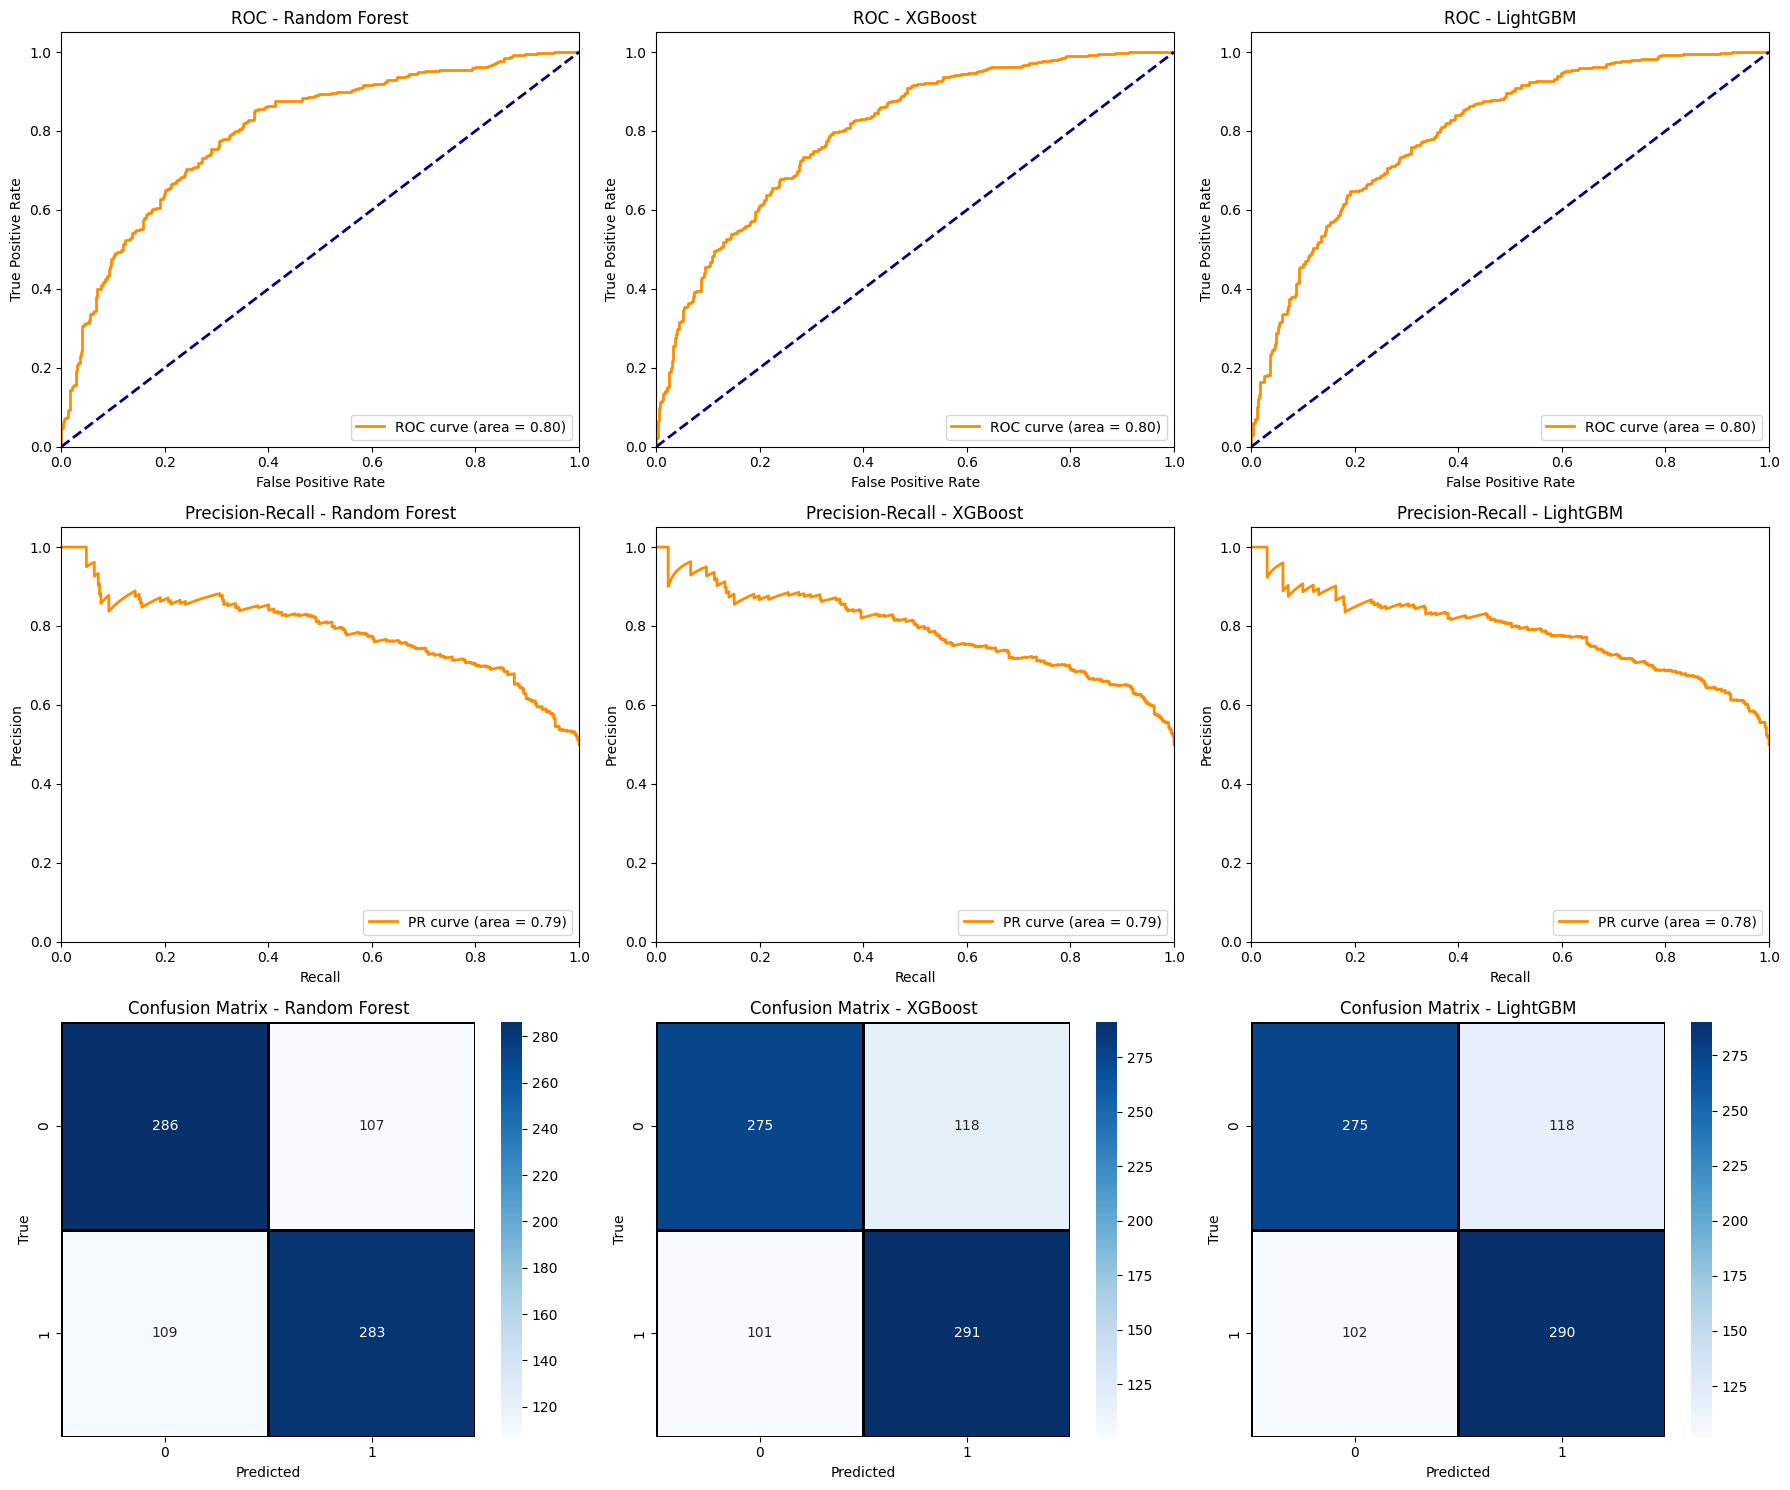

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.7248407643312101, 'Precision': 0.7256410256410256, 'Recall': 0.7219387755102041, 'F1 Score': 0.7237851662404092, 'ROC AUC': 0.7995079711273823}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7210191082802547, 'Precision': 0.7114914425427873, 'Recall': 0.7423469387755102, 'F1 Score': 0.7265917602996254, 'ROC AUC': 0.8020784649737759}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7197452229299363, 'Precision': 0.7107843137254902, 'Recall': 0.7397959183673469, 'F1 Score': 0.725, 'ROC AUC': 0.8027665264579114}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7197452229299363,
 'Precision': 0.7107843137254902,
 'Recall': 0.7397959183673469,
 'F1 Score': 0.725,
 'ROC AUC': 0.8027665264579114}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.7248


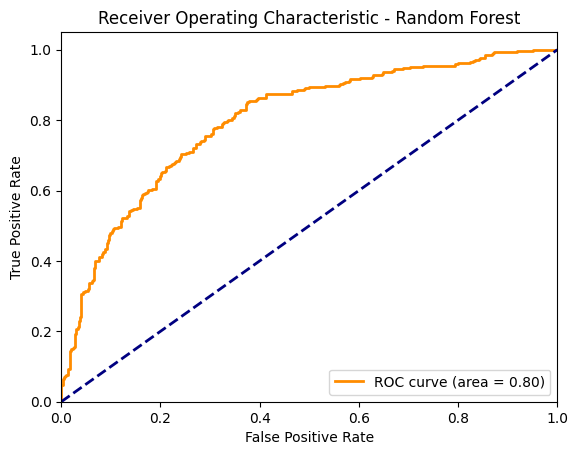

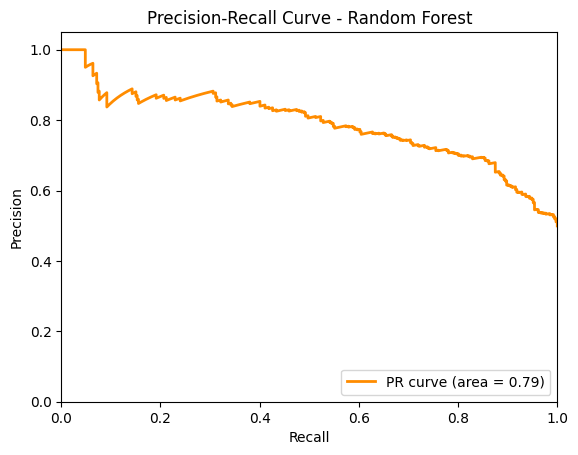

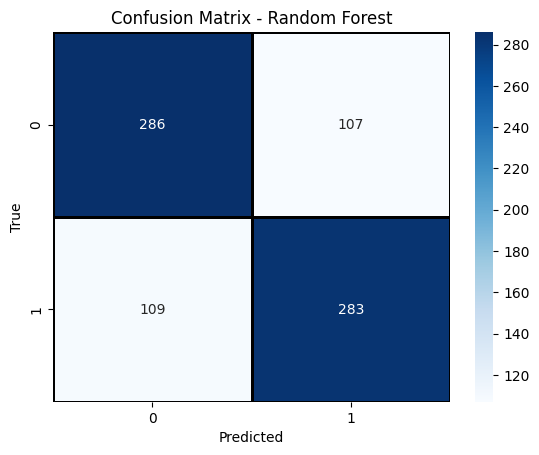

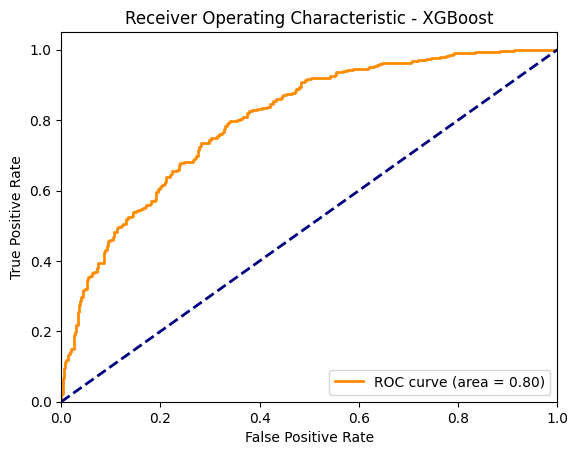

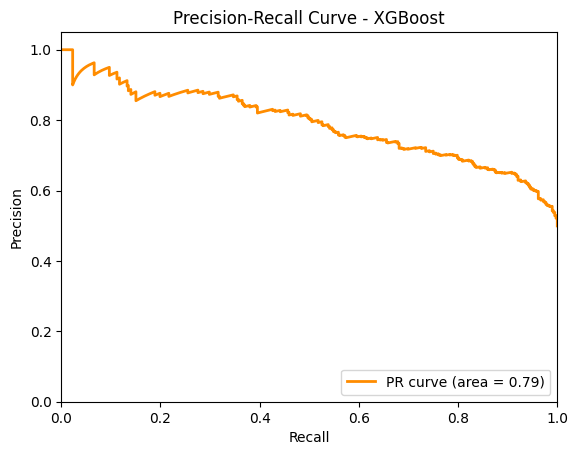

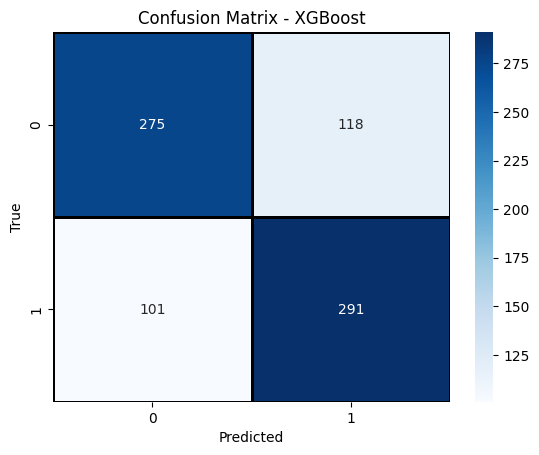

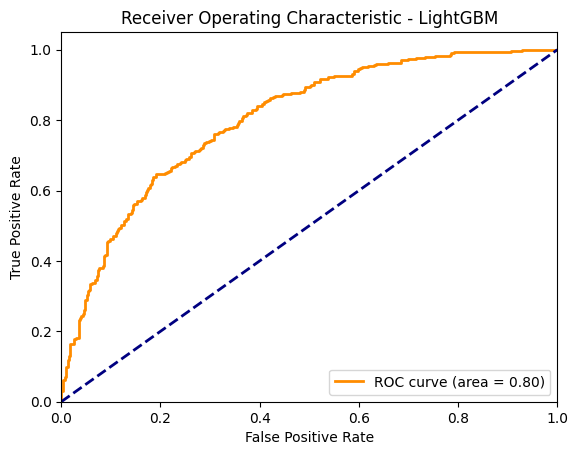

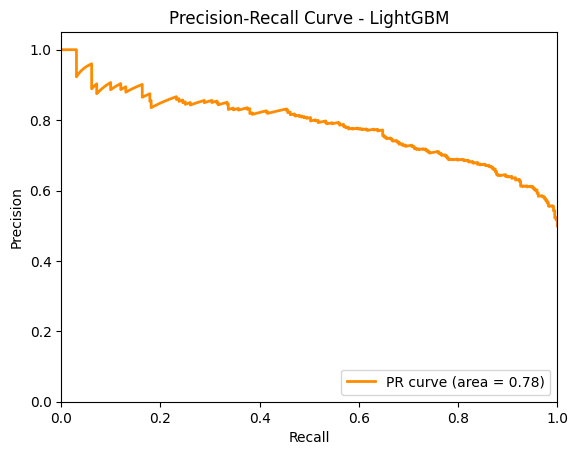

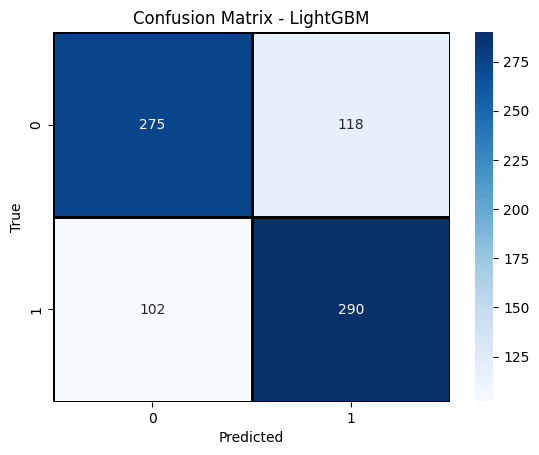

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

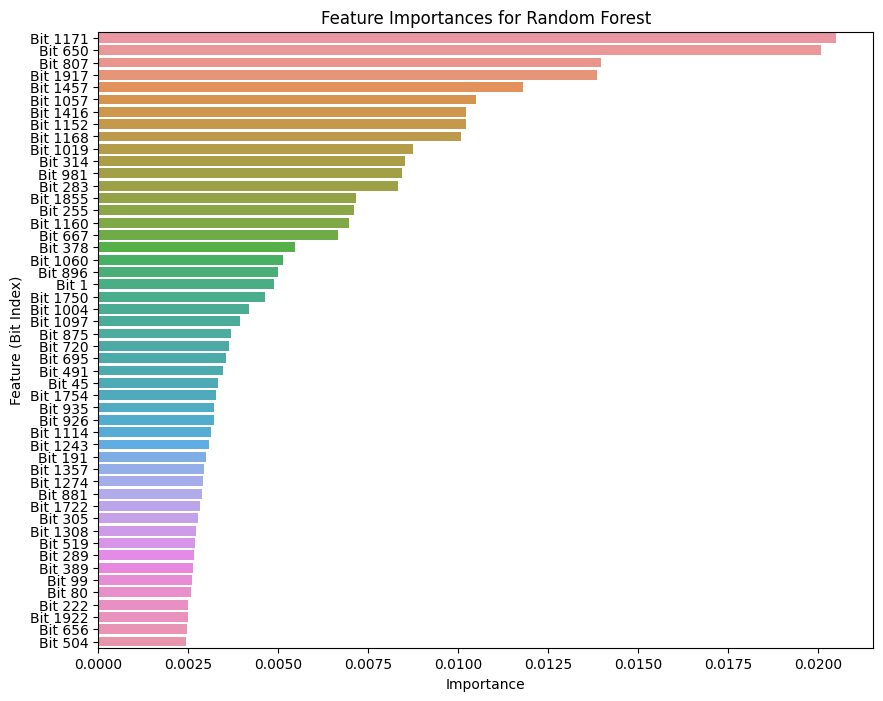

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
